In [1]:
# Imports 
# native
from collections import defaultdict
from collections import Counter
from itertools import repeat

# external
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Functions 
def count_seeds_from_tsv(tsv_file_path: str):
    counter = Counter()
    with open(tsv_file_path, 'r') as f:
        for record in f:
            seed, member = record.strip().split('\t')
            counter[seed] += 1
    return { 'seeds' : len(counter.keys()), 'proteins' : sum(counter.values()) }

# def count_homologues_in_each_seed(tsv_file_path: str):
#     counter = Counter()
#     with open(tsv_file_path, 'r') as f:
#         for record in f:
#             seed, member = record.strip().split('\t')
#             counter[seed] += 1
#     return tuple(counter.values())

def parse_mmseqs_seeds(seeds_tsv_file):
    """ 
    mmseqs2 tsv files are usually very big
    the idea here is to create a generator
    that will only read and yield a cluster
    at a time so my crappy pc can parse all
    data in chunks.
    For this to work the tsv mmseqs needs to be
    sorted by the first column.
    """
    
    format_df = lambda current_seed, members: pd.DataFrame(zip(repeat(current_seed), members), columns=('seeds', 'members'))
    
    with open(seeds_tsv_file) as f:
        
        current_seed = None
        members = []
                
        for record in f:
            seed, member = record.strip().split('\t')
            
            if current_seed and seed != current_seed:
                
                yield (current_seed, format_df(current_seed, members))
                
                current_seed = None
                members = []
                
            if not current_seed:
                current_seed = seed
                
            members.append(member)
            
        yield (current_seed, format_df(current_seed, members))
        



# Trying the icity approuch 
Let's try the [icity method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6003329/), this approuch consists on finding a set of baits (interest _loci_) and then trought the use of a few scoring functions (mainly icity) find nighboorhood genes that might have functional relationships.

## Clustering all _Salmonella_ proteins
All _Salmonella_ proteins annotated with prokka where merged in one file and clustered with mmseqs2 with min coverage (-c 0.9) and min identity (-min-ind-pct 0.9). The barplot bellow show the count of all proteins in the _Salmonella_ genomes and the count of seeds (clusters) after mmseqs2 clustering.

In [20]:
clustered_proteins_file = '/home/hugo/projects/salmonella-bacterial-immunity/clu_90_90.sorted.tsv'

seeds_and_proteins_count = count_seeds_from_tsv(clustered_proteins_file)
seeds_and_proteins_count

{'seeds': 264793, 'proteins': 74326142}

Text(0.5, 0.98, 'Count of seeds after mmseqs2 clustering')

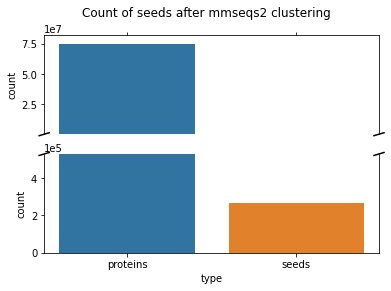

In [62]:
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/broken_axis.html

temp = pd.DataFrame(seeds_and_proteins_count.items(), columns=('type', 'count')).sort_values('count', ascending=False)

# create a 2 by 1 grid 
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# Create two plots (top and bottom)
sns.barplot(x='type', y='count', data=temp, ax=ax)
sns.barplot(x='type', y='count', data=temp, ax=ax2)

# Set sci notation to y
ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
# Set limit to top and bottom
bottom_limit = temp['count'].min() * 2
top_limit = temp['count'].max() * 1.1
ax.set_ylim(bottom_limit, top_limit)  # outliers only
ax2.set_ylim(0, bottom_limit)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax.set_xlabel('') # remove top xlabel

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Set title 
f.suptitle("Count of seeds after mmseqs2 clustering")

Before doing clustering we had approximately 74 million single proteins in all the 16,5 thousand genomes of _Salmonella_. This was reduced to 250 thousand seeds (clusters) after the mmseqs clustering. 

## Filtering out seeds that don't have defesense systems as neighbors

The idea of doing the clustering is to established relationships between the proteins on the genomes. So here we are going to drop seeds that don't a single homologus members that is a neighbor of a defesense system gene. 

In [6]:
seeds_mmseqs = '/home/hugo/projects/salmonella-bacterial-immunity/clu_90_90.sorted.tsv'
locus_tags_in_the_extracted_cassettes_file = '/home/hugo/projects/salmonella-bacterial-immunity/net_data_16K/neighborhood_baits_locus_tags.txt'
locus_tags_in_the_extracted_cassettes = set([
    record.strip()
    for record in open(locus_tags_in_the_extracted_cassettes_file, 'r')
])

In [31]:
with open(seeds_mmseqs) as f:
    interest_seeds = Counter()
    not_interest_seeds = Counter()
    for record in f:
        seed, member = record.strip().split('\t')
        if member in locus_tags_in_the_extracted_cassettes:
            interest_seeds[seed] += 1
            continue
        not_interest_seeds[seed] += 1

In [23]:
clusters_with_defesense_systems = set(interest_seeds.keys())

In [37]:
with open('/home/hugo/projects/salmonella-bacterial-immunity/seeds_neighborhood_all_locus_tags.txt', 'w') as f_out:
    with open(seeds_mmseqs) as f_in:
        for record in f_in:
            seed, member = record.strip().split('\t')
            if seed in clusters_with_defesense_systems:
                f_out.write(record)
                

2498993